In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from craftax.craftax_env import make_craftax_env_from_name
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
from craftax.craftax.renderer import render_craftax_pixels
from craftax.craftax import constants
import matplotlib.pyplot as plt
import craftax_env
from craftax.craftax.constants import Action

Loading textures from cache.
Textures successfully loaded from cache.


In [6]:
from craftax_env import CraftaxSymbolicEnvNoAutoReset
from jaxneurorl.wrappers import TimestepWrapper

render = jax.jit(partial(render_craftax_pixels, block_pixel_size=constants.BLOCK_PIXEL_SIZE_IMG))
def render_craftax(state):
    image = render_craftax_pixels(state, block_pixel_size=constants.BLOCK_PIXEL_SIZE_IMG)
    return image/255.0
    
render_craftax = jax.jit(render_craftax)

static_env_params = CraftaxSymbolicEnvNoAutoReset.default_static_params().replace(
    use_precondition=False)
env = TimestepWrapper(CraftaxSymbolicEnvNoAutoReset(static_env_params=static_env_params), True)
env_params = env.default_params.replace(
    # mob_despawn_distance=2,
    # day_length=3,
    world_seeds=None,
    # max_timesteps=1000,
)

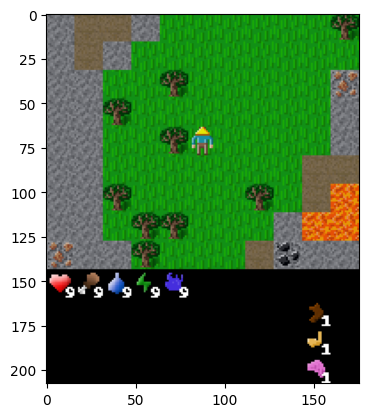


Currently achievable:
- Collect Coal
- Collect Iron
- Collect Stone
- Collect Wood


In [7]:
def show(t):
    image = render_craftax(t.state)
    plt.imshow(image)
    plt.show()
    possible = craftax_env.get_possible_achievements(t.state)
    craftax_env.print_possible_achievements(possible)

rng = jax.random.PRNGKey(19)
start_timestep = env.reset(rng, env_params)
show(start_timestep)
# start_timestep.state.passive_mobs

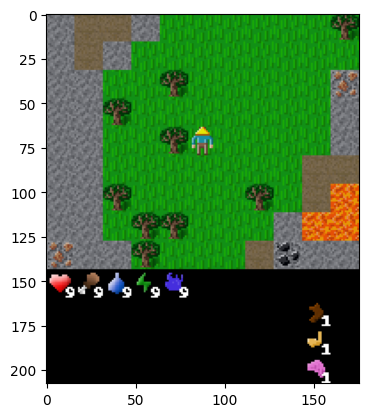


Currently achievable:
- Collect Coal
- Collect Iron
- Collect Stone
- Collect Wood


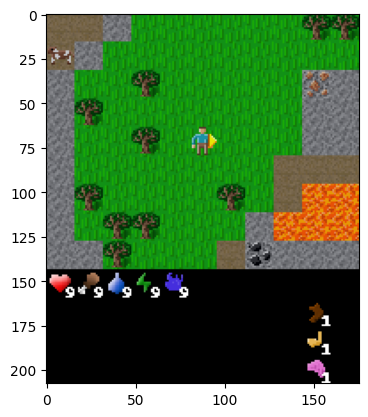

state.player_position [24 25]
obs_dim_array [ 9 11]
[21 21] [27 29]
[[21 20]
 [ 0  0]
 [ 0  0]] (3, 2)
state.player_position [24 25]
obs_dim_array [ 9 11]
[21 21] [27 29]
[[21 20]
 [ 0  0]
 [ 0  0]] (3, 2)
state.player_position [24 25]
obs_dim_array [ 9 11]
[21 21] [27 29]
[[21 20]
 [ 0  0]
 [ 0  0]] (3, 2)

Currently achievable:
- Collect Coal
- Collect Iron
- Collect Stone
- Collect Wood


In [19]:
rng = jax.random.PRNGKey(19)
start_timestep = env.reset(rng, env_params)
show(start_timestep)
rng_, rng = jax.random.split(rng, 2)
start_timestep = env.step(rng, start_timestep, jnp.array(Action.RIGHT.value), env_params)
show(start_timestep)



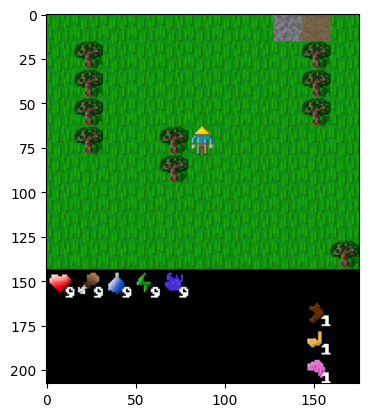


Currently achievable:
- Collect Stone
- Collect Wood
==================== 0 Action.LEFT ====================


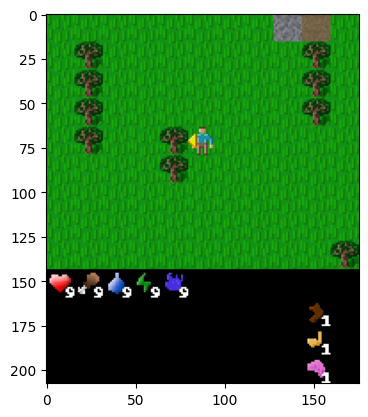


Currently achievable:
- Collect Stone
- Collect Wood
==================== 1 Action.DOWN ====================


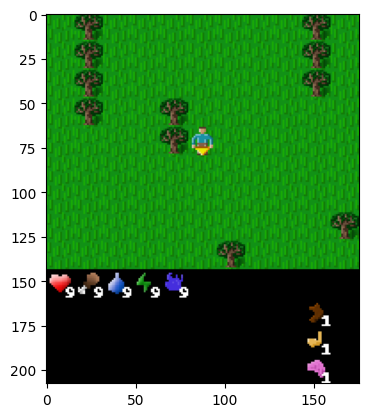


Currently achievable:
- Collect Wood
==================== 2 Action.LEFT ====================


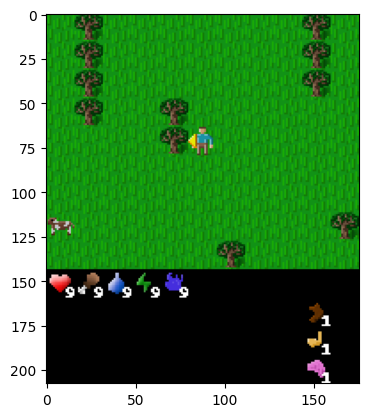


Currently achievable:
- Collect Wood
==================== 3 Action.DOWN ====================


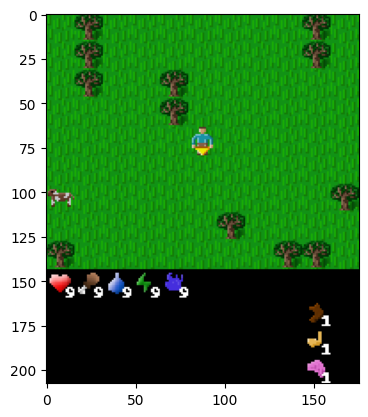


Currently achievable:
- Collect Wood
==================== 4 Action.LEFT ====================


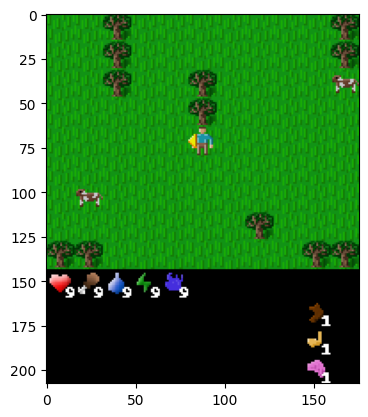


Currently achievable:
- Collect Wood
- Eat Cow
==================== 5 Action.DOWN ====================


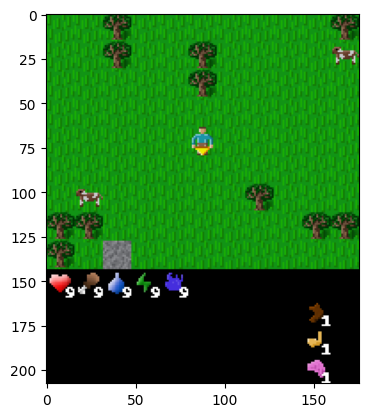


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow
==================== 6 Action.LEFT ====================


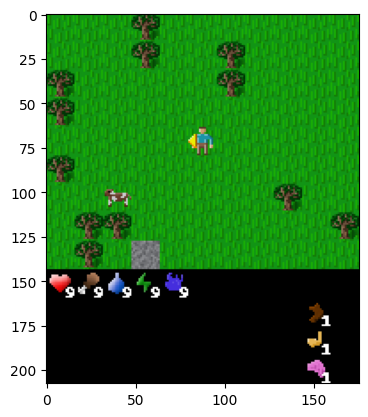


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow
==================== 7 Action.DOWN ====================


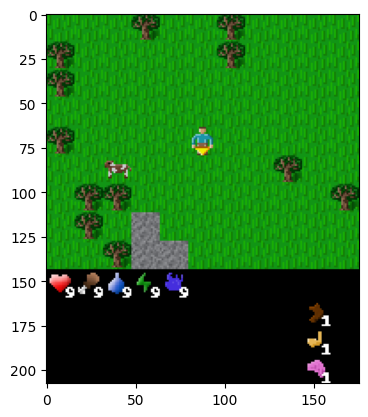


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow
==================== 8 Action.LEFT ====================


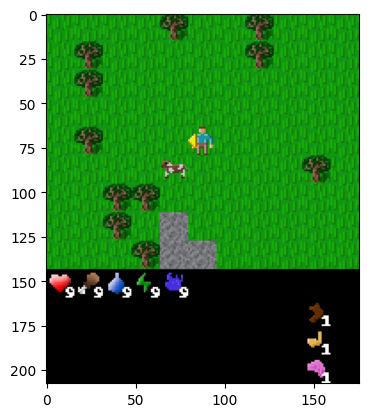


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow
==================== 9 Action.DOWN ====================


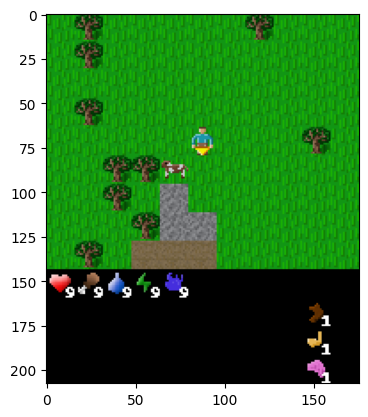


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow


In [20]:
rng = jax.random.PRNGKey(25)
start_timestep = env.reset(rng, env_params)
timestep = start_timestep
show(start_timestep)
# for t, a in enumerate([
#     Action.LEFT, Action.UP, Action.UP, Action.UP,
#     Action.LEFT, Action.LEFT, Action.LEFT, Action.LEFT, Action.LEFT, Action.LEFT
# ]):
for t, a in enumerate([Action.LEFT, Action.DOWN]*30):
    print('='*20, t, a, '='*20)
    rng_, rng = jax.random.split(rng, 2)
    timestep = env.step(rng, timestep, jnp.array(a.value), env_params)
    show(timestep)

    if t >= 9: break


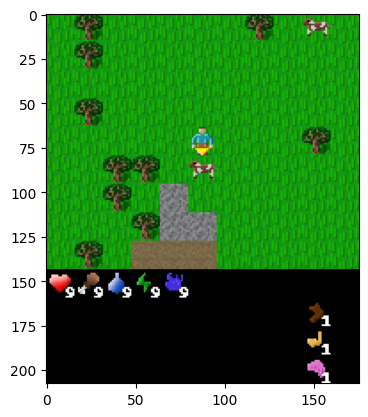


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow


In [71]:
rng_, rng = jax.random.split(rng, 2)
timestep = env.step(rng, timestep, jnp.array(Action.DOWN.value), env_params)
show(timestep)

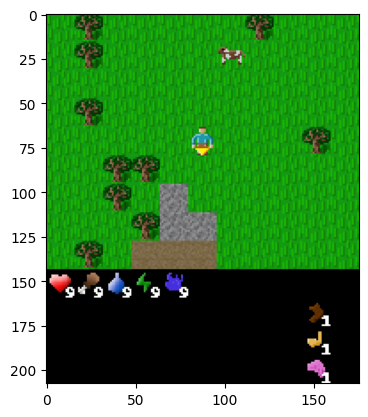


Currently achievable:
- Collect Stone
- Collect Wood
- Eat Cow


In [74]:
rng_, rng = jax.random.split(rng, 2)
timestep = env.step(rng, timestep, jnp.array(Action.DO.value), env_params)
show(timestep)

In [75]:
timestep.reward

Array(1., dtype=float32)

In [86]:
timestep.observation.achievable

Array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [84]:
achievable = timestep.observation.achievable.astype(jnp.float32)
any_achievable = achievable.sum() > .1
achieve_poss = achievable + 1e-5
achieve_poss = achieve_poss/achieve_poss.sum()
achieve_poss
import distrax
goals = distrax.Categorical(probs=achieve_poss).sample(
        seed=rng, sample_shape=(4))

In [85]:
goals

Array([2, 2, 9, 2], dtype=int32)

In [57]:
def check_mob_nearby(state, mob_type_id, mob_collection):
    # mob_collection = jax.tree.map(lambda x: x[state.player_level], mob_collection)
    OBS_DIM = (9, 11)
    obs_dim_array = jnp.array([OBS_DIM[0], OBS_DIM[1]], dtype=jnp.int32)
    MAX_OBS_DIM = max(OBS_DIM)
    # print('obs_dim_array', obs_dim_array)
    # print('obs_dim_array // 2', obs_dim_array // 2)
    # print('obs_dim_array // 2 + MAX_OBS_DIM + 2', obs_dim_array // 2 + MAX_OBS_DIM + 2)
    tl_corner = state.player_position - obs_dim_array // 2 + MAX_OBS_DIM + 2
    
    mob_positions = mob_collection.position[state.player_level]
    mob_types = mob_collection.type_id
    mob_masks = mob_collection.mask[state.player_level]

    print('state.player_position', state.player_position)
    # print('tl_corner', tl_corner)
    print('mob_positions', mob_positions)
    # print('mob_types', mob_types)
    # print('mob_masks', mob_masks)
    # print('tl_corner', tl_corner)
    # y_bottom = tl_corner[0] + OBS_DIM[0])
    # y_top = tl_corner[0]
    # x_top = tl_corner[1]

    # print(mob_positions[:, 0], " >= tl_corner[0]\t\t", tl_corner[0])
    # print(mob_positions[:, 0], " < tl_corner[0] - OBS_DIM[0]\t", tl_corner[0] - OBS_DIM[0])
    # print(mob_positions[:, 1], " >= tl_corner[1]\t\t", tl_corner[1])
    # print(mob_positions[:, 1], " < tl_corner[1] - OBS_DIM[1]\t", tl_corner[1] - OBS_DIM[1])
    player_y = state.player_position[0]
    player_x = state.player_position[1]
    print(mob_positions[:, 0], " < ", player_y + OBS_DIM[0])
    print(mob_positions[:, 0], " >= ", player_y - OBS_DIM[0])
    print(mob_positions[:, 1], " < ", player_x + OBS_DIM[1])
    print(mob_positions[:, 1], " >= ", player_x - OBS_DIM[1])
    low = state.player_position - obs_dim_array
    high = state.player_position + obs_dim_array
    is_visible = (
        (mob_positions[:, 0] < high[0]) &
        (mob_positions[:, 0] >= low[0]) &
        (mob_positions[:, 1] < high[1]) &
        (mob_positions[:, 1] >= low[1]) &
        mob_masks &
        (mob_types == mob_type_id)
    )
    return jnp.any(is_visible)
check_mob_nearby(timestep.state, 0, timestep.state.passive_mobs)

state.player_position [25 24]
mob_positions [[28 19]
 [ 0  1]
 [ 0  1]]
[28  0  0]  <  34
[28  0  0]  >=  16
[19  1  1]  <  35
[19  1  1]  >=  13


Array(True, dtype=bool)

In [85]:
tstep.state.player_position

Array([24, 25], dtype=int32)

In [9]:
from pprint import pprint
pprint(jax.tree.map(lambda x: x.shape, timestep.state))

EnvState(map=(9, 48, 48),
         item_map=(9, 48, 48),
         mob_map=(9, 48, 48),
         light_map=(9, 48, 48),
         down_ladders=(9, 2),
         up_ladders=(9, 2),
         chests_opened=(9,),
         monsters_killed=(9,),
         player_position=(2,),
         player_level=(),
         player_direction=(),
         player_health=(),
         player_food=(),
         player_drink=(),
         player_energy=(),
         player_mana=(),
         is_sleeping=(),
         is_resting=(),
         player_recover=(),
         player_hunger=(),
         player_thirst=(),
         player_fatigue=(),
         player_recover_mana=(),
         player_xp=(),
         player_dexterity=(),
         player_strength=(),
         player_intelligence=(),
         inventory=Inventory(wood=(),
                             stone=(),
                             coal=(),
                             iron=(),
                             diamond=(),
                             sapling=(),
    

In [ ]:
timestep..

----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to a

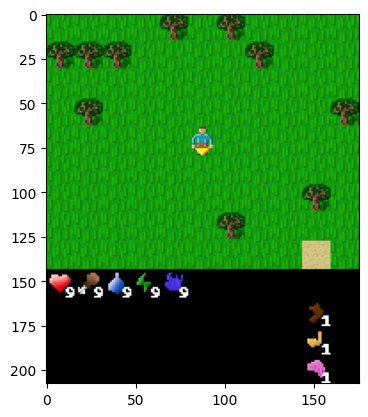

False

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


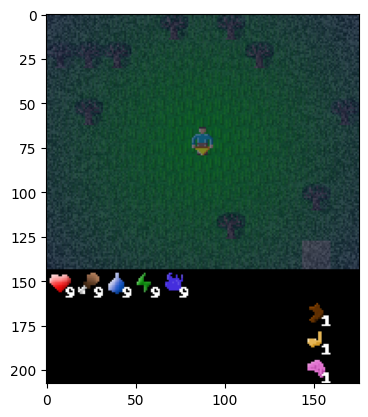

False

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


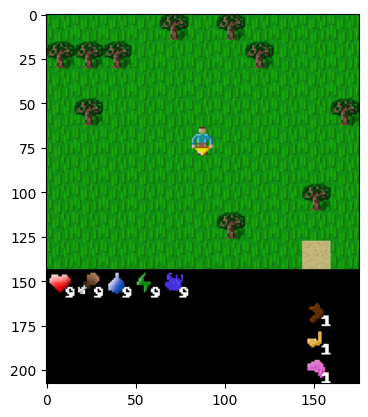

True

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


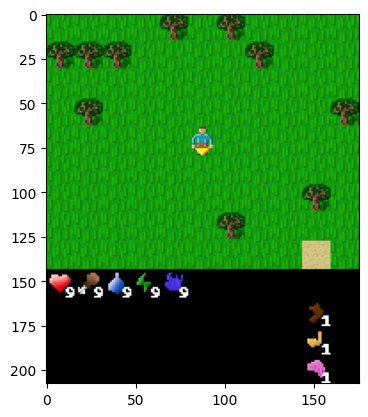

True


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)



Currently achievable:
- Collect Wood
----------


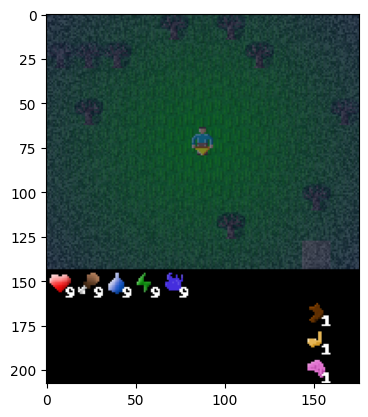

True

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


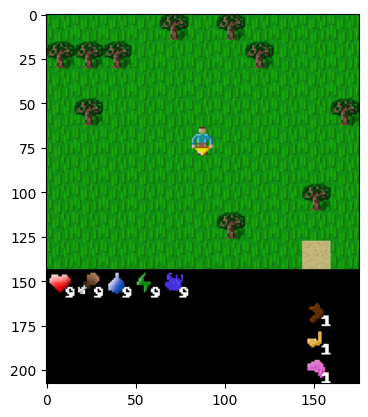

True

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


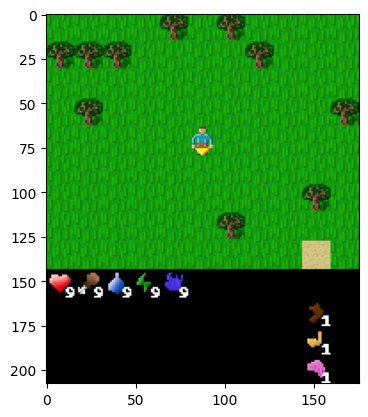

True


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)



Currently achievable:
- Collect Wood
----------


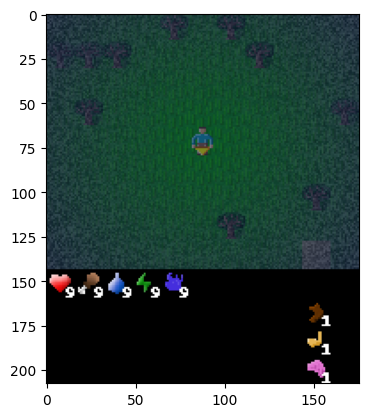

True

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


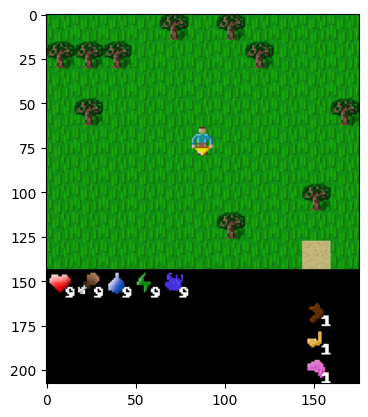

True

Currently achievable:
- Collect Wood
----------


/Users/wilka/miniforge3/envs/preplay-ai/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


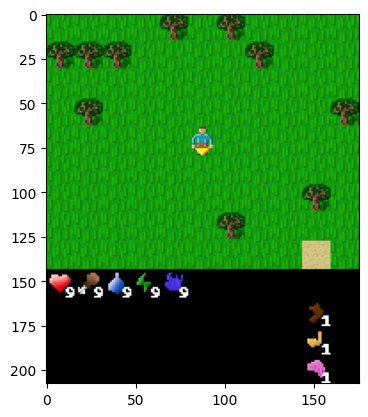

True

Currently achievable:
- Collect Wood


In [21]:
for _ in range(10):
    print('-'*10)
    rng, rng_ = jax.random.split(rng)
    action = env.action_space().sample(rng_)
    timestep = env.step(rng, timestep, action, env_params)
    image = render_craftax(timestep.state)
    plt.imshow(image)
    plt.show()
    print(timestep.last())
    possible = craftax_env.get_possible_achievements(timestep.state)
    craftax_env.print_possible_achievements(possible)
